What can a single neuron learn?

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import TensorDataset, random_split
import matplotlib.pyplot as plt
from typing import Callable

In [2]:
torch.manual_seed(0)
# Prepare dataset
# Generates polynomial data 
def polynomial_data_gen(eq: Callable[[torch.Tensor], torch.Tensor], n: int = 2, x_range: list = [0, 1], noise: float = 0):
    assert noise >= 0
    x = torch.linspace(x_range[0], x_range[1], n) 
    offset = torch.rand(n) * torch.randint(-noise, noise, (n,)) if noise else torch.zeros(n)
    y = eq(x) + offset
    return x, y

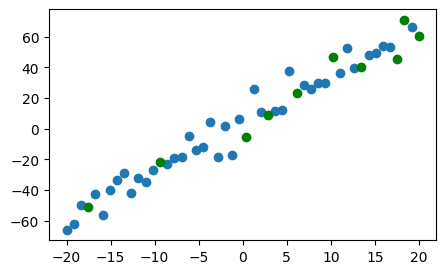

In [3]:
eq = lambda x: 3*x + 4
X , Y = polynomial_data_gen(eq, n = 50, x_range = [-20, 20], noise= 20)
r = 0.8
train_size = int(len(X) * r) 
test_size = len(X) - train_size
train, test =  random_split(TensorDataset(X, Y), [train_size, test_size])
x_train, y_train = train[:]
x_test, y_test= test[:]

fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(x_train, y_train)
ax.scatter(x_test, y_test, color='green')

In [4]:
class CustomLinearNet(nn.Module):
    def __init__(self, _in_s: int, _out_s: int, layer_conf: list):
        super().__init__()
        self._layers = nn.ModuleList(
            [getattr(torch.nn, layer_type)(**kwargs) for layer_type, kwargs in layer_conf]
        )
    
    def forward(self, x):
        for layer in self._layers:
            x = layer(x)
        return x 

In [5]:
model = CustomLinearNet(1, 1, [('Linear', {'in_features': 1, 'out_features': 1})])
print(f"Model: \n{model}")

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001) # 0.01 does not converge

EPOCH = 15

y_train_reshaped = y_train.reshape(-1, 1)
x_train_reshaped = x_train.reshape(-1, 1)

print("Training loop:")
for epoch in range(EPOCH):
    
    # Forward pass
    ypred = model.forward(x_train_reshaped)
    
    # zero-grad
    optimizer.zero_grad()
   
    # Backward pass
    loss = criterion(ypred, y_train_reshaped)
    loss.backward()
    
    # Update
    optimizer.step()
    
    print(f"epoch {epoch}, Loss: {loss.item()}")

Model: 
CustomLinearNet(
  (_layers): ModuleList(
    (0): Linear(in_features=1, out_features=1, bias=True)
  )
)
Training loop:
epoch 0, Loss: 1999.480712890625
epoch 1, Loss: 1136.105712890625
epoch 2, Loss: 661.1348876953125
epoch 3, Loss: 399.81585693359375
epoch 4, Loss: 256.0213928222656
epoch 5, Loss: 176.87429809570312
epoch 6, Loss: 133.28834533691406
epoch 7, Loss: 109.2637939453125
epoch 8, Loss: 95.99967956542969
epoch 9, Loss: 88.65481567382812
epoch 10, Loss: 84.56617736816406
epoch 11, Loss: 82.26888275146484
epoch 12, Loss: 80.9571533203125
epoch 13, Loss: 80.187744140625
epoch 14, Loss: 79.71683502197266


[Parameter containing:
tensor([[3.0459]], requires_grad=True), Parameter containing:
tensor([-0.8253], requires_grad=True)]



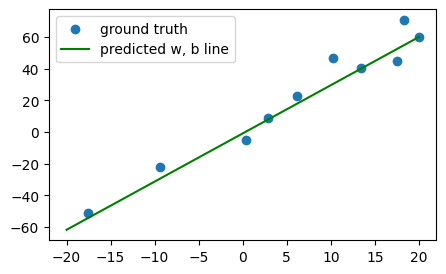

In [6]:
x_test_reshaped = x_test.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

ypred = model.forward(x_test_reshaped)
print(f"{list(model.parameters())}\n")

fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(x_test, y_test, label="ground truth")
x_best_fit = torch.linspace(-20, 20, 5)
param = list(model.parameters())
y_best_fit = (param[0].data * x_best_fit + param[1].data).squeeze()
ax.plot(x_best_fit, y_best_fit, color = 'green', label="predicted w, b line")
ax.legend()

Nice. Data points that lie on a hyperplane can be accurately predicted using just a single neuron.